# Customer Churn Prediction — Music Streaming (English Notebook)

This notebook walks through an end‑to‑end churn modeling workflow for a subscription-based music streaming service:

**Contents**
1. Data loading & quick checks (types, nulls)
2. Churn labeling **without leakage** (first `Cancellation Confirmation` and per-user `cutoff_time`)
3. Feature engineering at user level (activity counts, time features, page counters, ratios, last level)
4. Train/test split (stratified by label) and optional **time-based** split
5. Modeling (Logistic Regression baseline, Random Forest selected)
6. Threshold tuning for the operating point (best F1 / PR-driven)
7. Evaluation (ROC-AUC, PR-AUC, Precision/Recall/F1, confusion matrix)
8. Error analysis (Top False Positives / False Negatives)
9. Artifact export (`churn_model.joblib`) and feature order
10. Monitoring baseline & checks (`monitor.py`): PSI (data drift) + PR-AUC drop (concept drift)
11. Serving with FastAPI: `/predict_proba`, `/predict`

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
    
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 180)

In [2]:
df_chrun = pd.read_json(r"C:\Users\amhamim\Desktop\customer_churn.json", encoding="utf-8", lines=True)
df_log = pd.read_json(r"C:\Users\amhamim\Desktop\customer_churn_mini.json", encoding="utf-8", lines=True)
# df_chrun.head()

# with open(r"C:\Users\amhamim\Desktop\customer_churn.json", encoding="utf-8") as f:
#     data = json.load(f)
# df = pd.json_normalize(data)
# df.head()

In [97]:
df_chrun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             543705 non-null  int64  
 1   userId         543705 non-null  object 
 2   sessionId      543705 non-null  int64  
 3   page           543705 non-null  object 
 4   auth           543705 non-null  object 
 5   method         543705 non-null  object 
 6   status         543705 non-null  int64  
 7   level          543705 non-null  object 
 8   itemInSession  543705 non-null  int64  
 9   location       528005 non-null  object 
 10  userAgent      528005 non-null  object 
 11  lastName       528005 non-null  object 
 12  firstName      528005 non-null  object 
 13  registration   528005 non-null  float64
 14  gender         528005 non-null  object 
 15  artist         432877 non-null  object 
 16  song           432877 non-null  object 
 17  length         432877 non-nul

In [98]:
df_chrun.describe()

,ts,sessionId,status,itemInSession,registration,length
count,5.437050e+05,543705.000000,543705.000000,543705.000000,5.280050e+05,432877.000000
mean,1.540965e+12,2040.814353,210.018291,107.306291,1.535523e+12,248.664593
std,1.482057e+09,1434.338931,31.471919,116.723508,3.078725e+09,98.412670
min,1.538352e+12,1.000000,200.000000,0.000000,1.509854e+12,0.783220
25%,1.539720e+12,630.000000,200.000000,26.000000,1.534368e+12,199.392200
50%,1.541005e+12,1968.000000,200.000000,68.000000,1.536556e+12,234.004440
75%,1.542177e+12,3307.000000,200.000000,147.000000,1.537612e+12,276.793020
max,1.543622e+12,4808.000000,404.000000,1005.000000,1.543074e+12,3024.665670


In [99]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             286500 non-null  int64  
 1   userId         286500 non-null  object 
 2   sessionId      286500 non-null  int64  
 3   page           286500 non-null  object 
 4   auth           286500 non-null  object 
 5   method         286500 non-null  object 
 6   status         286500 non-null  int64  
 7   level          286500 non-null  object 
 8   itemInSession  286500 non-null  int64  
 9   location       278154 non-null  object 
 10  userAgent      278154 non-null  object 
 11  lastName       278154 non-null  object 
 12  firstName      278154 non-null  object 
 13  registration   278154 non-null  float64
 14  gender         278154 non-null  object 
 15  artist         228108 non-null  object 
 16  song           228108 non-null  object 
 17  length         228108 non-nul

In [100]:
df_log.describe()

,ts,sessionId,status,itemInSession,registration,length
count,2.865000e+05,286500.000000,286500.000000,286500.000000,2.781540e+05,228108.000000
mean,1.540957e+12,1041.526555,210.054597,114.414213,1.535359e+12,249.117182
std,1.507544e+09,726.776263,31.505078,129.767262,3.291322e+09,99.235179
min,1.538352e+12,1.000000,200.000000,0.000000,1.521381e+12,0.783220
25%,1.539697e+12,336.000000,200.000000,27.000000,1.533522e+12,199.888530
50%,1.540932e+12,1013.000000,200.000000,70.000000,1.536664e+12,234.500770
75%,1.542266e+12,1675.000000,200.000000,156.250000,1.537672e+12,277.158730
max,1.543799e+12,2474.000000,404.000000,1321.000000,1.543247e+12,3024.665670


In [3]:
df_chrun.corr()

C:\Users\amhamim\AppData\Local\Temp\3\ipykernel_23844\4088591539.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_chrun.corr()


,ts,sessionId,status,itemInSession,registration,length
ts,1.000000,0.695748,-0.004526,0.068325,0.015543,-0.002820
sessionId,0.695748,1.000000,-0.021120,0.143711,-0.019600,-0.002675
status,-0.004526,-0.021120,1.000000,-0.009383,0.001630,NaN
itemInSession,0.068325,0.143711,-0.009383,1.000000,0.000728,0.001599
registration,0.015543,-0.019600,0.001630,0.000728,1.000000,-0.000432
length,-0.002820,-0.002675,NaN,0.001599,-0.000432,1.000000


In [4]:
df_log.corr()

C:\Users\amhamim\AppData\Local\Temp\3\ipykernel_23844\1147385698.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_log.corr()


,ts,sessionId,status,itemInSession,registration,length
ts,1.000000,0.696380,-0.003886,0.052067,-0.006120,0.002143
sessionId,0.696380,1.000000,-0.019877,0.105216,0.029362,0.004369
status,-0.003886,-0.019877,1.000000,-0.006444,0.000567,NaN
itemInSession,0.052067,0.105216,-0.006444,1.000000,-0.038562,-0.002837
registration,-0.006120,0.029362,0.000567,-0.038562,1.000000,0.002695
length,0.002143,0.004369,NaN,-0.002837,0.002695,1.000000


In [103]:
df_chrun.isnull().sum()

ts                    0
userId                0
sessionId             0
page                  0
auth                  0
method                0
status                0
level                 0
itemInSession         0
location          15700
userAgent         15700
lastName          15700
firstName         15700
registration      15700
gender            15700
artist           110828
song             110828
length           110828
dtype: int64

In [104]:
df_log.isnull().sum()

ts                   0
userId               0
sessionId            0
page                 0
auth                 0
method               0
status               0
level                0
itemInSession        0
location          8346
userAgent         8346
lastName          8346
firstName         8346
registration      8346
gender            8346
artist           58392
song             58392
length           58392
dtype: int64

In [114]:
df_chrun.groupby(['song', 'page']) \
        .size() \
        .reset_index(name='count') \
        .sort_values('count', ascending=False)\
        .head(1000)

,song,page,count
79449,You're The One,NextSong,2219
73162,Undo,NextSong,1938
54762,Revelry,NextSong,1613
57519,Sehr kosmisch,NextSong,1341
28760,Horn Concerto No. 4 in E flat K495: II. Romanc...,NextSong,1236
16795,Dog Days Are Over (Radio Edit),NextSong,1048
57379,Secrets,NextSong,916
73535,Use Somebody,NextSong,894
10470,Canada,NextSong,836
33451,Invalid,NextSong,801


In [125]:
df_chrun.groupby(['page'])\
        .size() 

page
About                          1855
Add Friend                     8087
Add to Playlist               12349
Cancel                           99
Cancellation Confirmation        99
Downgrade                      3811
Error                           519
Help                           3150
Home                          27412
Login                          6011
Logout                         5990
NextSong                     432877
Register                         11
Roll Advert                    7773
Save Settings                   585
Settings                       2964
Submit Downgrade                117
Submit Registration               4
Submit Upgrade                  287
Thumbs Down                    4911
Thumbs Up                     23826
Upgrade                         968
dtype: int64

In [126]:
df_log.groupby(['page'])\
        .size() 

page
About                           924
Add Friend                     4277
Add to Playlist                6526
Cancel                           52
Cancellation Confirmation        52
Downgrade                      2055
Error                           258
Help                           1726
Home                          14457
Login                          3241
Logout                         3226
NextSong                     228108
Register                         18
Roll Advert                    3933
Save Settings                   310
Settings                       1514
Submit Downgrade                 63
Submit Registration               5
Submit Upgrade                  159
Thumbs Down                    2546
Thumbs Up                     12551
Upgrade                         499
dtype: int64

In [121]:
df_chrun["page"].nunique()

22

In [5]:
# import datetime as dt

df_chrun["length"] = df_chrun["length"].apply(lambda x: str(dt.timedelta(seconds=float(x))).split(".")[0] if pd.notnull(x) else np.nan)
df_log["length"] = df_log["length"].apply(lambda x: str(dt.timedelta(seconds=float(x))).split(".")[0] if pd.notnull(x) else np.nan)


In [6]:
df_chrun["registration"] = pd.to_datetime(df_chrun["registration"], unit="ms", errors="coerce")
df_log["registration"]   = pd.to_datetime(df_log["registration"], unit="ms", errors="coerce")
df_chrun["ts"] = pd.to_datetime(df_chrun["ts"], unit="ms", errors="coerce")
df_log["ts"]   = pd.to_datetime(df_log["ts"], unit="ms", errors="coerce")

In [7]:
df_chrun.head()
# df_log.head()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,2018-10-01 00:00:11,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,2018-07-20 05:11:47,M,Martin Orford,Grand Designs,0:09:57
1,2018-10-01 00:00:25,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,2018-09-27 17:33:58,M,John Brown's Body,Bulls,0:06:20
2,2018-10-01 00:01:58,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,2018-09-03 05:44:15,M,Afroman,Because I Got High,0:03:22
3,2018-10-01 00:01:59,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,2018-09-03 05:44:15,M,NaN,NaN,NaN
4,2018-10-01 00:02:04,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,2018-09-02 23:30:18,F,Lily Allen,Smile (Radio Edit),0:03:14


In [8]:
def guess_user_id_col(df):
    for c in ["userId", "user_id", "userid", "UserId"]:
        if c in df.columns:
            return c
    raise KeyError("userId can't be found. updated.")

UID = guess_user_id_col(df_log)
UID2 = guess_user_id_col(df_chrun)

def clean_user_id(s):
    return (
        s.astype(str)
         .str.strip()
         .replace({"": np.nan, "null": np.nan, "None": np.nan})
    )

df_log = df_log.copy()
df_chrun = df_chrun.copy()

df_log[UID] = clean_user_id(df_log[UID])
df_chrun[UID2] = clean_user_id(df_chrun[UID2])


df_log = df_log[~df_log[UID].isna()]
df_chrun = df_chrun[~df_chrun[UID2].isna()]


ts_col = None
for c in ["ts", "timestamp", "event_ts"]:
    if c in df_log.columns:
        ts_col = c
        break

if ts_col is not None:

    if df_log[ts_col].dtype != "datetime64[ns]":

        if pd.to_numeric(df_log[ts_col], errors="coerce").dropna().median() > 1e12:
            df_log["event_time"] = pd.to_datetime(df_log[ts_col], unit="ms", errors="coerce", utc=True).dt.tz_convert(None)
        else:
            df_log["event_time"] = pd.to_datetime(df_log[ts_col], errors="coerce", utc=True).dt.tz_convert(None)
    else:
        df_log["event_time"] = df_log[ts_col]
else:

    df_log["event_time"] = df_log.groupby(UID).cumcount()


In [9]:

def guess_churn_col(df):
    for c in ["churn", "Churn", "is_churn", "churned", "label"]:
        if c in df.columns:
            return c
    return None

label_col = guess_churn_col(df_chrun)

if label_col is None:

    page_col = None
    for c in ["page", "Page", "event", "event_name"]:
        if c in df_log.columns:
            page_col = c
            break

    if page_col is None:
        raise KeyError(" not working . label updated .")

    churn_events = df_log[df_log[page_col] == "Cancellation Confirmation"].groupby(UID)["event_time"].min().rename("cancel_time")
    churn_flag = (churn_events.notna()).astype(int).rename("churn")
    labels = churn_flag.reset_index()
else:

    tmp = df_chrun[[UID2, label_col]].copy()
 
    mapping = {"yes":1,"no":0,"true":1,"false":0,"1":1,"0":0,True:1,False:0}
    tmp[label_col] = tmp[label_col].map(lambda x: mapping.get(str(x).strip().lower(), x))
    tmp[label_col] = pd.to_numeric(tmp[label_col], errors="coerce").fillna(0).astype(int)
    labels = tmp.rename(columns={UID2: UID, label_col: "churn"}).drop_duplicates(subset=[UID])


In [10]:

if "cancel_time" not in df_log.columns:
    # churn logs cancel_time.:
    page_col = page_col if 'page_col' in locals() else ("page" if "page" in df_log.columns else None)
    if page_col is not None:
        cancel_time_series = df_log[df_log[page_col] == "Cancellation Confirmation"].groupby(UID)["event_time"].min()
    else:
        cancel_time_series = pd.Series(index=labels[UID], dtype="datetime64[ns]")
else:
    cancel_time_series = df_log.groupby(UID)["cancel_time"].min()

user_last_time = df_log.groupby(UID)["event_time"].max().rename("last_time")

cutoff = pd.concat([labels.set_index(UID)["churn"], cancel_time_series.rename("cancel_time"), user_last_time], axis=1)
cutoff["cutoff_time"] = np.where(cutoff["churn"]==1, cutoff["cancel_time"], cutoff["last_time"])
cutoff = cutoff.drop(columns=["cancel_time"]).reset_index()

#  cutoff 
df_log_cut = df_log.merge(cutoff[[UID, "cutoff_time"]], on=UID, how="inner")
df_log_cut = df_log_cut[df_log_cut["event_time"] <= df_log_cut["cutoff_time"]].copy()


In [11]:

LOG = df_log_cut.copy()  


page_col    = "page"      if "page"      in LOG.columns else None
session_col = "sessionId" if "sessionId" in LOG.columns else None
song_col    = "song"      if "song"      in LOG.columns else None
length_col  = "length"    if "length"    in LOG.columns else None
level_col   = "level"     if "level"     in LOG.columns else None

#length
if "event_time" in LOG.columns:
    LOG["event_time"] = pd.to_datetime(LOG["event_time"], errors="coerce")
if length_col:
    LOG[length_col] = pd.to_numeric(LOG[length_col], errors="coerce")


agg_dict = {}
agg_dict["event_count"] = (UID, "size")  
if session_col: agg_dict["n_sessions"]   = (session_col, pd.Series.nunique)
if song_col:    agg_dict["n_songs"]      = (song_col, lambda s: s.notna().sum())
if length_col:  agg_dict["avg_song_len"] = (length_col, "mean")

# tenure و recency
time_stats = (
    LOG.groupby(UID, dropna=False)["event_time"]
       .agg(first_time="min", last_time="max")
       .reset_index()
)
time_stats["tenure_days"]  = (time_stats["last_time"] - time_stats["first_time"]).dt.total_seconds() / 86400.0
global_last_time = LOG["event_time"].max()
time_stats["recency_days"] = (global_last_time - time_stats["last_time"]).dt.total_seconds() / 86400.0


basic = LOG.groupby(UID, dropna=False).agg(**agg_dict).reset_index()
features = basic.merge(time_stats[[UID, "tenure_days", "recency_days"]], on=UID, how="left")

#  (Thumbs Up/Down/...)
if page_col:
    # one-hot
    page_counts = pd.DataFrame({UID: LOG[UID].values})
    interesting_pages = [
        "Thumbs Up","Thumbs Down","Add to Playlist","Add Friend","Roll Advert",
        "Help","Settings","Error","Downgrade","Upgrade","Logout","Home","NextSong"
    ]
    for p in interesting_pages:
        col_name = f"page__{p.replace(' ','_')}"
        page_counts[col_name] = (LOG[page_col] == p).astype(int)


    one_hot_cols = [c for c in page_counts.columns if c.startswith("page__")]
    page_agg = (
        page_counts.groupby(UID, as_index=False)[one_hot_cols]
                   .sum()
    )
    features = features.merge(page_agg, on=UID, how="left")


if level_col:

    last_level = (
        LOG.sort_values(["event_time"])
           .groupby(UID, as_index=False)[level_col]
           .last()
           .rename(columns={level_col: "last_level"})
    )

  # pivot
    level_counts = (
        LOG[[UID, level_col]]
        .pivot_table(index=UID, columns=level_col, values=level_col, aggfunc="count", fill_value=0)
    )
    level_counts.columns = [f"level_count__{str(c)}" for c in level_counts.columns]
    level_counts = level_counts.reset_index()

    features = (
        features.merge(last_level, on=UID, how="left")
                .merge(level_counts, on=UID, how="left")
    )


if "n_sessions" in features.columns and "event_count" in features.columns:
    features["events_per_session"] = features["event_count"] / features["n_sessions"].replace(0, np.nan)

if "n_songs" in features.columns and "n_sessions" in features.columns:
    features["songs_per_session"] = features["n_songs"] / features["n_sessions"].replace(0, np.nan)

#  churn
dataset = features.merge(labels[[UID, "churn"]], on=UID, how="inner").copy()

#  df_chrun 
demographic_cols = []
for c in ["gender","Gender","location","state","plan","Level","PaymentMethod"]:
    if c in df_chrun.columns:
        demographic_cols.append(c)
demographic_cols = list(dict.fromkeys(demographic_cols)) 

if demographic_cols:
    demo = (
        df_chrun[[UID2] + demographic_cols]
        .drop_duplicates(subset=[UID2])
        .rename(columns={UID2: UID})
    )
    dataset = dataset.merge(demo, on=UID, how="left")


count_cols = [c for c in dataset.columns if c.startswith("page__") or c.startswith("level_count__")]
for c in count_cols:
    dataset[c] = dataset[c].fillna(0).astype(int)


for c in ["tenure_days","recency_days","events_per_session","songs_per_session",
          "avg_song_len","n_sessions","n_songs","event_count"]:
    if c in dataset.columns:
        dataset[c] = pd.to_numeric(dataset[c], errors="coerce")


dataset = dataset.replace([np.inf, -np.inf], np.nan)

print("final shape of the table:", dataset.shape)
dataset.head()


final shape of the table: (52, 26)


,userId,event_count,n_sessions,n_songs,avg_song_len,tenure_days,recency_days,page__Thumbs_Up,page__Thumbs_Down,page__Add_to_Playlist,page__Add_Friend,page__Roll_Advert,page__Help,page__Settings,page__Error,page__Downgrade,page__Upgrade,page__Logout,page__Home,page__NextSong,last_level,events_per_session,songs_per_session,churn,gender,location
0,100001,187,4,133,NaN,1.408576,61.357303,8,2,3,2,14,1,1,1,0,2,7,11,133,free,46.750000,33.25,1,F,"Miami-Fort Lauderdale-West Palm Beach, FL"
1,100003,78,2,51,NaN,2.018067,52.369155,3,0,2,0,9,1,0,0,0,0,3,7,51,free,39.000000,25.50,1,F,"Miami-Fort Lauderdale-West Palm Beach, FL"
2,100005,216,5,154,NaN,18.111227,44.301516,7,3,3,3,18,2,2,0,0,4,3,15,154,free,43.200000,30.80,1,M,"Monroe, LA"
3,100006,44,1,26,NaN,0.064884,58.407477,2,2,1,4,3,0,1,0,0,0,1,2,26,free,44.000000,26.00,1,F,"Flint, MI"
4,100007,520,9,423,NaN,58.177153,3.559803,19,6,9,17,5,3,3,0,7,0,5,20,423,paid,57.777778,47.00,1,F,"Little Rock-North Little Rock-Conway, AR"


In [12]:
target = "churn"
id_col = UID


exclude = {id_col, target, "first_time", "last_time", "cutoff_time"} & set(dataset.columns)
X = dataset.drop(columns=list(exclude))
y = dataset[target]


cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if const_cols:
    X = X.drop(columns=const_cols)
    cat_cols = [c for c in cat_cols if c not in const_cols]
    num_cols = [c for c in num_cols if c not in const_cols]

print("Categorical:", cat_cols)
print("Numeric:", len(num_cols))

# stratify
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


Categorical: ['last_level', 'gender', 'location']
Numeric: 20


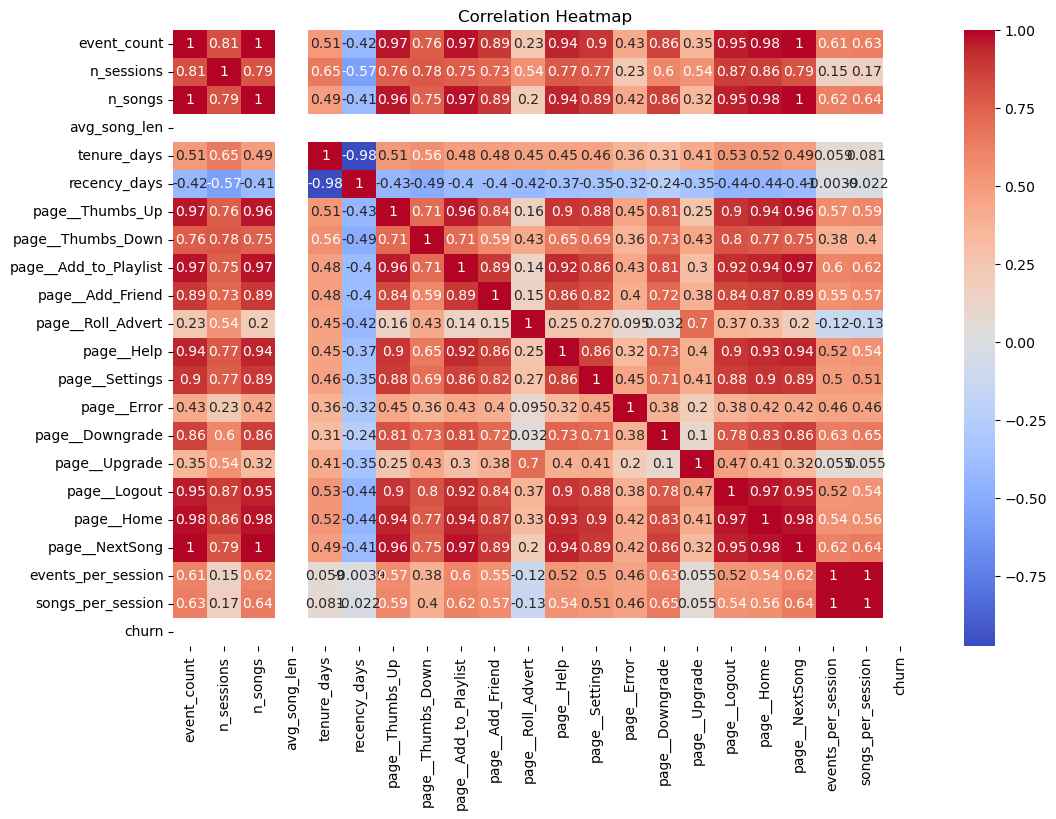

In [150]:
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


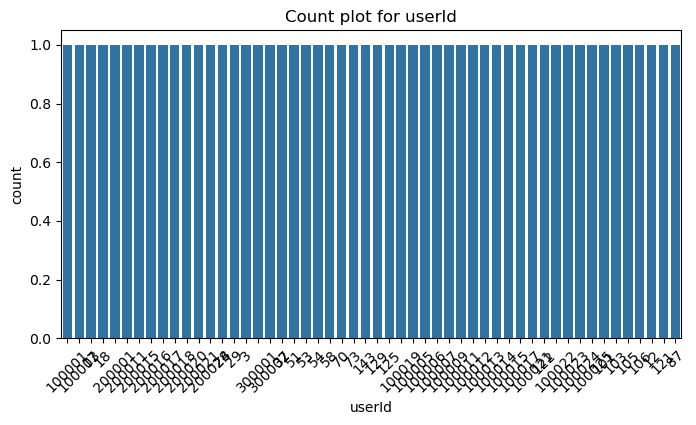

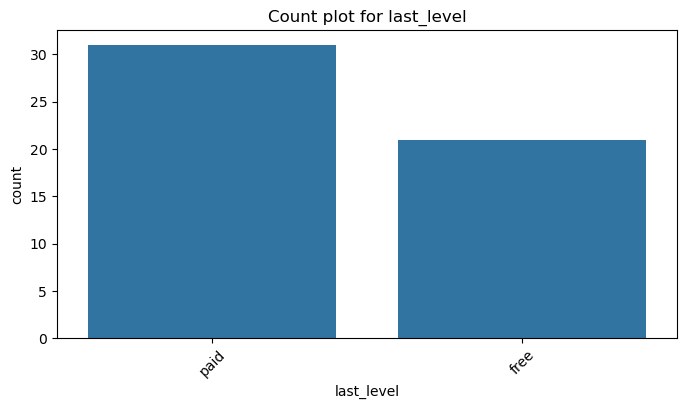

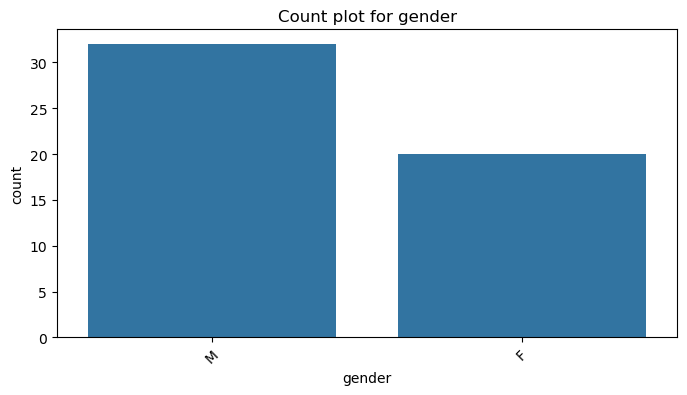

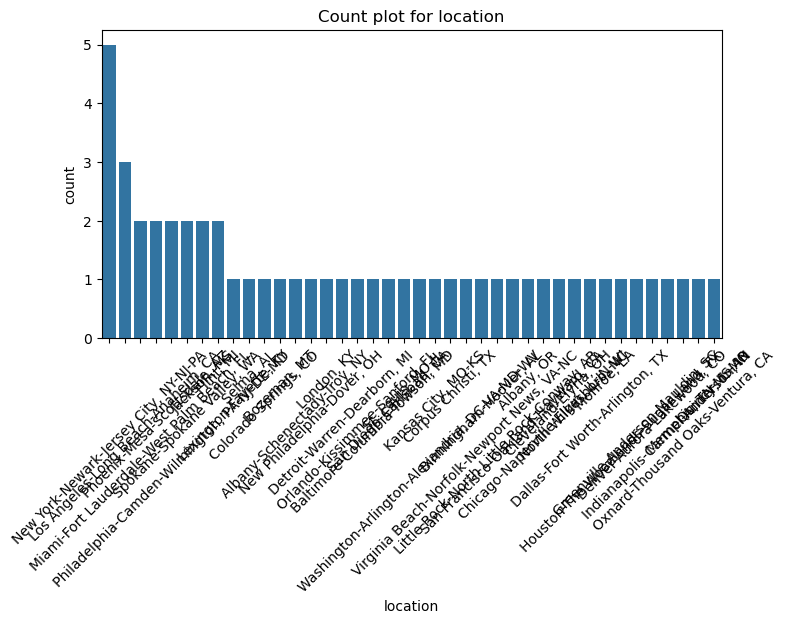

In [151]:
cat_cols = dataset.select_dtypes(include="object").columns

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=dataset, x=col, order=dataset[col].value_counts().index)
    plt.title(f"Count plot for {col}")
    plt.xticks(rotation=45)
    plt.show()


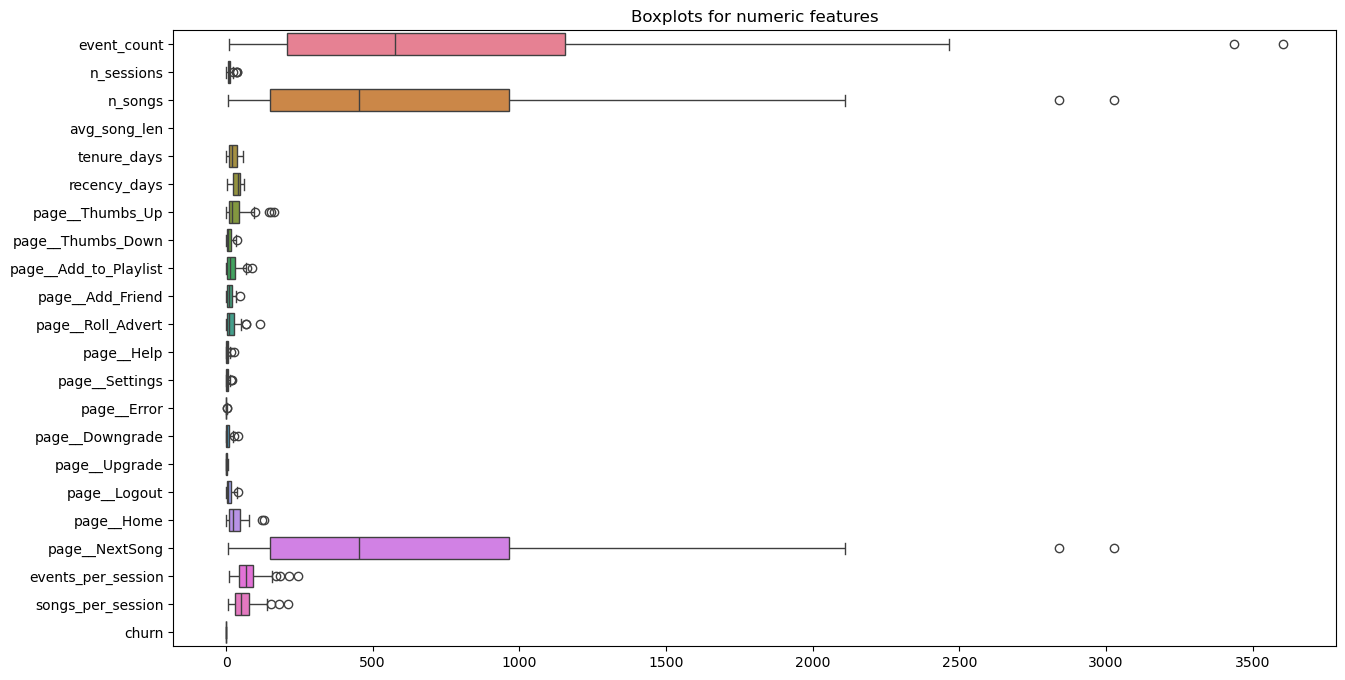

In [152]:
# import seaborn as sns

plt.figure(figsize=(15, 8))
sns.boxplot(data=dataset.select_dtypes(include="number"), orient="h")
plt.title("Boxplots for numeric features")
plt.show()


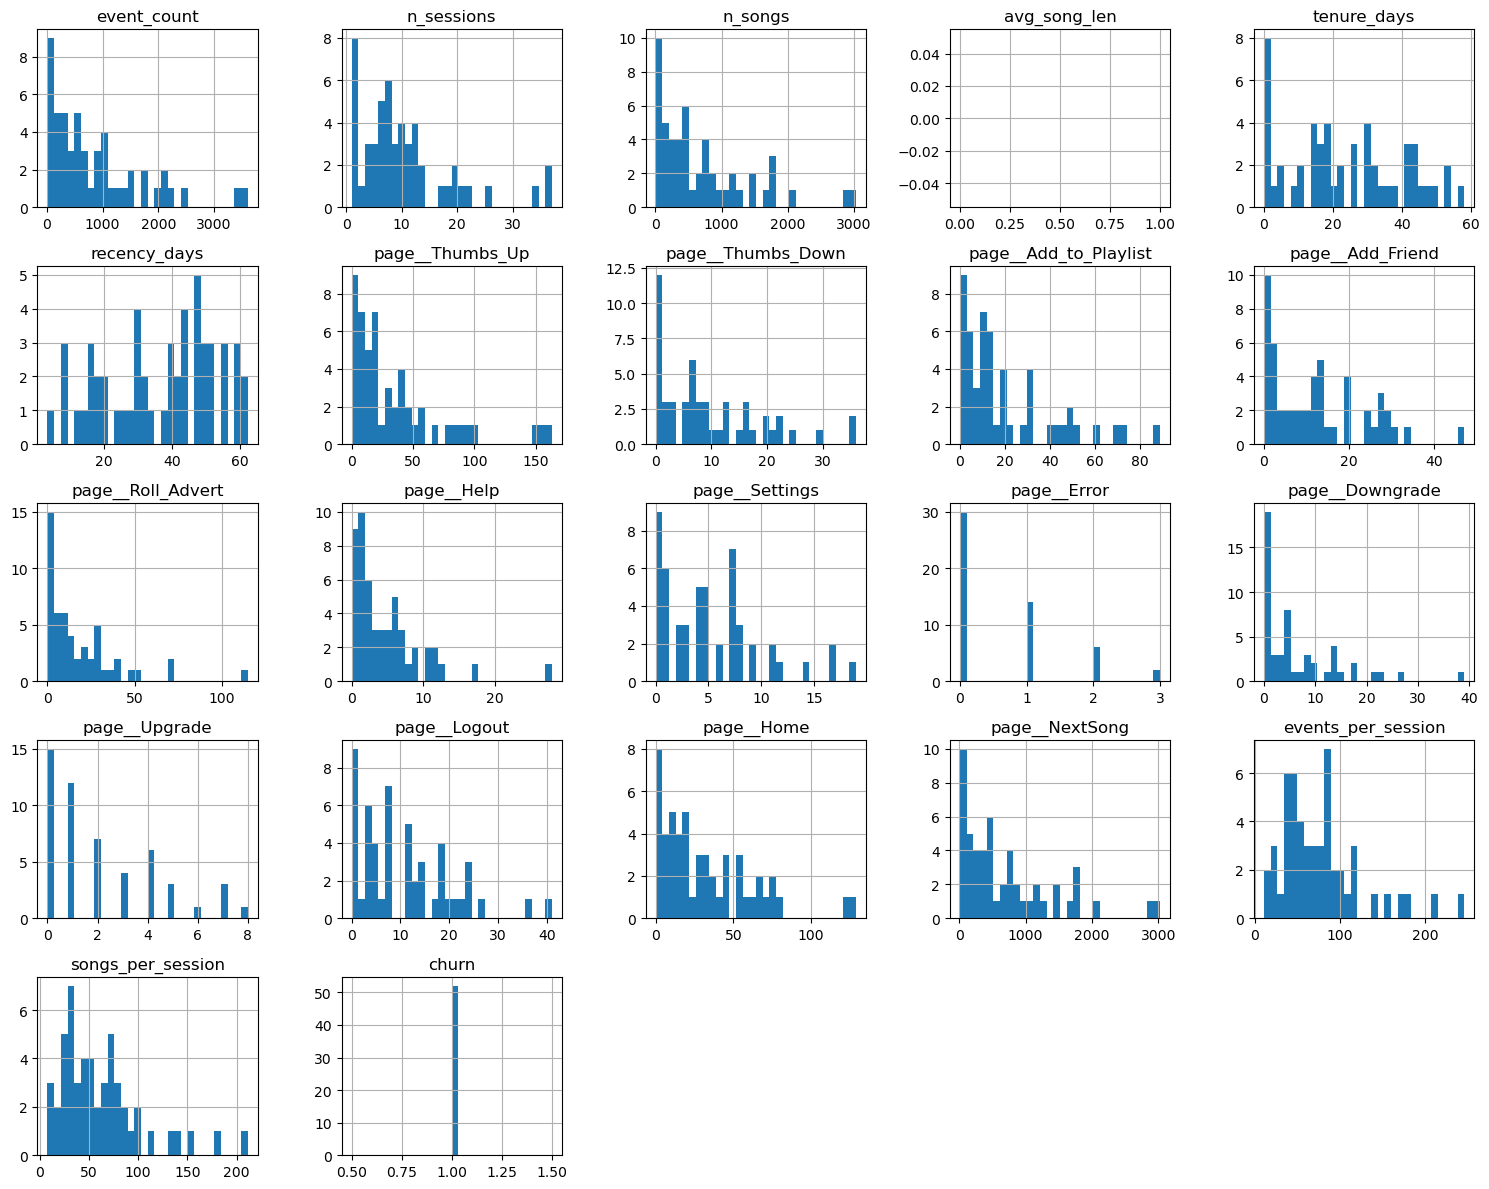

In [153]:
# import matplotlib.pyplot as plt

# histograms for all numeric columns
dataset.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()


In [27]:

all_users = pd.DataFrame({UID: df_log[UID].dropna().unique()})


page_col = "page" if "page" in df_log.columns else None
if page_col is None:
    raise KeyError("'page' df_log .")

cancel_time = (
    df_log[df_log[page_col] == "Cancellation Confirmation"]
      .groupby(UID)["event_time"].min()
      .rename("cancel_time")
)


labels = all_users.merge(cancel_time, on=UID, how="left")
labels["churn"] = labels["cancel_time"].notna().astype(int)

print("labels value_counts():")
print(labels["churn"].value_counts())


labels value_counts():
0    173
1     52
Name: churn, dtype: int64


In [14]:

user_last_time = df_log.groupby(UID)["event_time"].max().rename("last_time").reset_index()

cutoff = (
    labels.merge(user_last_time, on=UID, how="left")
          .assign(cutoff_time=lambda d: np.where(d["churn"]==1, d["cancel_time"], d["last_time"]))
          [[UID, "churn", "cutoff_time"]]
)


df_log_cut = (
    df_log.merge(cutoff, on=UID, how="inner")
          .query("event_time <= cutoff_time")
          .copy()
)


valid = (df_log_cut.query("churn==1")["event_time"] <= df_log_cut.query("churn==1")["cutoff_time"]).all()
print("Leakage check:", valid)


Leakage check: True


In [15]:
print("labels:", labels["churn"].value_counts(), "\n")

print("df_log_cut users by churn (unique users):")
print(df_log_cut.groupby("churn")[UID].nunique(), "\n")

print("features users:", features[UID].nunique())
print("features head users:", features[UID].head().tolist(), "\n")

print("dataset churn counts BEFORE split:")
print(dataset["churn"].value_counts())


labels: 0    173
1     52
Name: churn, dtype: int64 

df_log_cut users by churn (unique users):
churn
0    173
1     52
Name: userId, dtype: int64 

features users: 225
features head users: ['10', '100', '100001', '100002', '100003'] 

dataset churn counts BEFORE split:
1    52
Name: churn, dtype: int64


In [24]:
print("dataset shape:", dataset.shape)
print("dataset churn counts:\n", dataset["churn"].value_counts())


dataset shape: (52, 26)
dataset churn counts:
 1    52
Name: churn, dtype: int64


In [16]:
labels_full = labels[[UID, "churn"]].copy()

#  Normalize 
features[UID]    = features[UID].astype(str).str.strip()
labels_full[UID] = labels_full[UID].astype(str).str.strip()

print("dtypes:", features[UID].dtype, labels_full[UID].dtype)

# diagnostics
probe = features.merge(labels_full, on=UID, how="left", indicator=True)
print("merge indicator:\n", probe["_merge"].value_counts())
missing_keys = probe.loc[probe["_merge"]!="both", UID].unique().tolist()
print("Sample missing keys (if any):", missing_keys[:10])

# Finalize
dataset = probe.drop(columns=["_merge"]).copy()

# checks
print("dataset rows:", len(dataset))
print("dataset churn counts:\n", dataset["churn"].value_counts(dropna=False))

# In that unexpected case, inspect :
if dataset["churn"].isna().any():
    print("Unexpected NaN churn rows (showing a few):")
    display(dataset.loc[dataset["churn"].isna(), [UID]].head(10))


dtypes: object object
merge indicator:
 both          225
left_only       0
right_only      0
Name: _merge, dtype: int64
Sample missing keys (if any): []
dataset rows: 225
dataset churn counts:
 0    173
1     52
Name: churn, dtype: int64


In [17]:
# from sklearn.model_selection import train_test_split

target = "churn"; id_col = UID
exclude = {id_col, target, "first_time", "last_time", "cutoff_time"} & set(dataset.columns)

X = dataset.drop(columns=list(exclude))
y = dataset[target]

cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if const_cols:
    X = X.drop(columns=const_cols)
    cat_cols = [c for c in cat_cols if c not in const_cols]
    num_cols = [c for c in num_cols if c not in const_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train:", y_train.value_counts().to_dict(), "| Test:", y_test.value_counts().to_dict())


Train: {0: 129, 1: 39} | Test: {0: 44, 1: 13}


In [18]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

numeric_tf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
categorical_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# 1) Logistic Regression
log_reg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
log_reg.fit(X_train, y_train)
y_proba_lr = log_reg.predict_proba(X_test)[:,1]
y_pred_lr  = log_reg.predict(X_test)
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC :", average_precision_score(y_test, y_proba_lr))

# 2) Random Forest
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])
rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf  = rf.predict(X_test)
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC :", average_precision_score(y_test, y_proba_rf))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        44
           1       0.61      0.85      0.71        13

    accuracy                           0.84        57
   macro avg       0.78      0.84      0.80        57
weighted avg       0.87      0.84      0.85        57

ROC-AUC: 0.9388111888111889
PR-AUC : 0.8343452843452843

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        44
           1       0.91      0.77      0.83        13

    accuracy                           0.93        57
   macro avg       0.92      0.87      0.89        57
weighted avg       0.93      0.93      0.93        57

ROC-AUC: 0.9790209790209791
PR-AUC : 0.940574382882075


In [22]:
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, f1_score

proba = y_proba_rf  
prec, rec, thr = precision_recall_curve(y_test, proba)


f1s = [f1_score(y_test, (proba >= t).astype(int)) for t in thr]
best_ix = int(np.argmax(f1s))
best_thr = float(thr[best_ix])

print(f"Best threshold ~ {best_thr:.3f}, F1={f1s[best_ix]:.3f}, Precision={prec[best_ix]:.3f}, Recall={rec[best_ix]:.3f}")


y_pred_best = (proba >= best_thr).astype(int)
print(classification_report(y_test, y_pred_best))


Best threshold ~ 0.423, F1=0.846, Precision=0.846, Recall=0.846
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.85      0.85      0.85        13

    accuracy                           0.93        57
   macro avg       0.90      0.90      0.90        57
weighted avg       0.93      0.93      0.93        57



In [31]:
ohe = rf.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
feature_names = np.r_[num_cols, cat_names]

importances = rf.named_steps["clf"].feature_importances_
imp_df = (pd.DataFrame({"feature": feature_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(20))
display(imp_df)


,feature,importance
4,recency_days,0.289922
3,tenure_days,0.194228
8,page__Add_Friend,0.041972
19,songs_per_session,0.041231
1,n_sessions,0.037278
5,page__Thumbs_Up,0.035673
17,page__NextSong,0.033925
2,n_songs,0.032173
9,page__Roll_Advert,0.031882
18,events_per_session,0.031320


In [32]:

users_time = cutoff[[UID, "cutoff_time", "churn"]].dropna().copy()
users_time = users_time.sort_values("cutoff_time")
cut = users_time["cutoff_time"].quantile(0.8)  

train_u = set(users_time.loc[users_time["cutoff_time"] <= cut, UID])
test_u  = set(users_time.loc[users_time["cutoff_time"]  > cut, UID])

X_all = dataset.drop(columns=[UID, "churn"])
y_all = dataset["churn"]
train_idx = dataset[UID].isin(train_u)
test_idx  = dataset[UID].isin(test_u)

X_train_t, X_test_t = X_all[train_idx], X_all[test_idx]
y_train_t, y_test_t = y_all[train_idx], y_all[test_idx]
print("Time split:", y_train_t.value_counts().to_dict(), y_test_t.value_counts().to_dict())


Time split: {0: 128, 1: 52} {0: 45}


In [33]:
# from sklearn.calibration import CalibratedClassifierCV

rf_base = rf.named_steps["clf"]
prep    = rf.named_steps["prep"]

Xtr_p = prep.fit_transform(X_train, y_train)
Xte_p = prep.transform(X_test)

rf_base.fit(Xtr_p, y_train)
rf_cal = CalibratedClassifierCV(rf_base, method="isotonic", cv=3).fit(Xtr_p, y_train)

proba_cal = rf_cal.predict_proba(Xte_p)[:,1]



In [34]:
for a, b, name in [
    ("page__Thumbs_Up",     "event_count",   "thumbs_up_rate"),
    ("page__Thumbs_Down",   "event_count",   "thumbs_down_rate"),
    ("page__Add_to_Playlist","event_count",  "add_playlist_rate"),
    ("page__Add_Friend",    "event_count",   "add_friend_rate"),
    ("page__Error",         "event_count",   "error_rate"),
    ("n_songs",             "event_count",   "songs_per_event"),
]:
    if a in dataset.columns and b in dataset.columns:
        dataset[name] = dataset[a] / dataset[b].replace(0, np.nan)


In [35]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import average_precision_score, roc_auc_score
# import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_list, pr_list = [], []
for tr, te in skf.split(X, y):
    rf.fit(X.iloc[tr], y.iloc[tr])
    proba = rf.predict_proba(X.iloc[te])[:,1]
    roc_list.append(roc_auc_score(y.iloc[te], proba))
    pr_list.append(average_precision_score(y.iloc[te], proba))

print(f"ROC-AUC CV: {np.mean(roc_list):.3f} ± {np.std(roc_list):.3f}")
print(f"PR-AUC  CV: {np.mean(pr_list):.3f} ± {np.std(pr_list):.3f}")


ROC-AUC CV: 0.920 ± 0.058
PR-AUC  CV: 0.856 ± 0.089


In [36]:
def precision_at_k(y_true, y_score, k=0.1):
    k = max(1, int(np.ceil(len(y_score) * k)))
    idx = np.argsort(-y_score)[:k]
    return y_true.iloc[idx].mean()  # لأن y {0,1}

p_at_10 = precision_at_k(y_test, y_proba_rf, k=0.10)
print("Precision@10%:", round(float(p_at_10), 3))


Precision@10%: 1.0


In [37]:
# from sklearn.inspection import permutation_importance

rf.fit(X_train, y_train)
res = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, scoring="average_precision")
perm_imp = pd.DataFrame({"feature": X.columns, "perm_importance": res.importances_mean}).sort_values("perm_importance", ascending=False)
perm_imp.head(20)


,feature,perm_importance
4,recency_days,0.439716
3,tenure_days,0.034581
9,page__Roll_Advert,0.031665
6,page__Thumbs_Down,0.028494
1,n_sessions,0.014645
15,page__Logout,0.013033
7,page__Add_to_Playlist,0.012843
11,page__Settings,0.011368
0,event_count,0.010261
5,page__Thumbs_Up,0.009651


In [38]:
# import joblib, json, time

best_threshold = 0.423
artifact = {
    "model": rf, 
    "threshold": best_threshold,
    "feature_order": X.columns.tolist(),
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S")
}
joblib.dump(artifact, "churn_model.joblib")
print("Saved: churn_model.joblib")


Saved: churn_model.joblib


In [42]:
# app.py
from fastapi import FastAPI
import joblib
import pandas as pd

app = FastAPI()
art = joblib.load("churn_model.joblib")
pipe = art["model"]; thr = art["threshold"]; feat_order = art["feature_order"]

@app.post("/predict_proba")
def predict_proba(payload: dict):
    X = pd.DataFrame([payload])[feat_order]
    p = float(pipe.predict_proba(X)[:,1][0])
    return {"churn_probability": p}

@app.post("/predict")
def predict(payload: dict):
    X = pd.DataFrame([payload])[feat_order]
    p = float(pipe.predict_proba(X)[:,1][0])
    y = int(p >= thr)
    return {"churn_probability": p, "prediction": y, "threshold": thr}


In [44]:
# in Jupyter
X_train.assign(churn=y_train).to_csv("C:/Users/amhamim/Desktop/project_v1/data/baseline_batch.csv", index=False)
X_test.assign(churn=y_test).to_csv("C:/Users/amhamim/Desktop/project_v1/data/new_batch.csv", index=False)


In [48]:
X_test.assign(churn=y_test).to_csv("C:/Users/amhamim/Desktop/project_v1/monitoring/batches/new_batch.csv", index=False)


In [50]:
# choose your baseline window (e.g., X_train or a historical month)
train_proba = rf.predict_proba(X_train)[:,1]
np.save("C:/Users/amhamim/Desktop/project_v1/monitoring/baseline_scores.npy", train_proba)

from sklearn.metrics import average_precision_score
with open("C:/Users/amhamim/Desktop/project_v1/monitoring/baseline_metrics.json","w") as f:
    json.dump({"pr_auc": float(average_precision_score(y_train, train_proba)),
               "n": int(len(y_train))}, f, indent=2)


In [51]:
import numpy as np, pandas as pd, joblib, json
art = joblib.load("churn_model.joblib")
pipe = art["model"]; feat_order = art["feature_order"]
df = pd.read_csv("C:/Users/amhamim/Desktop/project_v1/monitoring/batches/new_batch.csv")
scores = pipe.predict_proba(df[feat_order])[:,1]
np.save("C:/Users/amhamim/Desktop/project_v1/monitoring/reports/2025-09-15_scores.npy", scores)


Threshold used: 0.423

Confusion matrix [TN FP; FN TP]:
 [[42  2]
 [ 2 11]]

Classification report:
               precision    recall  f1-score   support

           0      0.955     0.955     0.955        44
           1      0.846     0.846     0.846        13

    accuracy                          0.930        57
   macro avg      0.900     0.900     0.900        57
weighted avg      0.930     0.930     0.930        57


Top 10 False Positives:


,proba,margin_from_thr,y_true,y_pred,event_count,n_sessions,n_songs,tenure_days,recency_days,page__Thumbs_Up,page__Thumbs_Down,page__Add_to_Playlist
89,0.556667,0.133667,0,1,259,1,216,0.628380,53.700984,5,2,8
112,0.493333,0.070333,0,1,456,8,348,34.901968,27.510961,16,10,5



Top 10 False Negatives:


,proba,margin_from_thr,y_true,y_pred,event_count,n_sessions,n_songs,tenure_days,recency_days,page__Thumbs_Up,page__Thumbs_Down,page__Add_to_Playlist
110,0.270000,0.153000,1,0,1498,36,1169,47.095405,15.354560,56,36,32
105,0.326667,0.096333,1,0,349,11,258,37.001794,23.757095,10,10,13



Saved: monitoring/reports/eval_with_errors_20250915_112246.csv, monitoring/reports/topFP_20250915_112246.csv, monitoring/reports/topFN_20250915_112246.csv


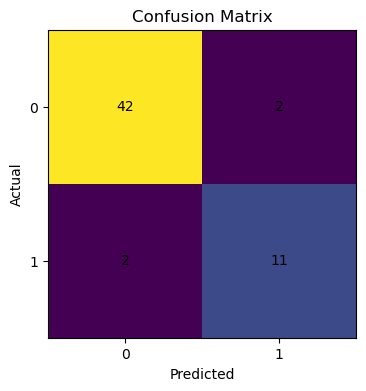


Error analysis summary:
 {
  "n": 57,
  "TP": 11,
  "TN": 42,
  "FP": 2,
  "FN": 2,
  "threshold": 0.423,
  "top_FP_file": "monitoring/reports/topFP_20250915_112246.csv",
  "top_FN_file": "monitoring/reports/topFN_20250915_112246.csv"
}


In [26]:
import os, joblib , time, json

art = joblib.load("churn_model.joblib")
pipe = art["model"]
feat_order = art["feature_order"]
thr = float(art.get("threshold", 0.5))


USE_IN_MEMORY_TEST = True  

if USE_IN_MEMORY_TEST:
 
    X_eval = X_test[feat_order].copy()
    y_eval = y_test.to_numpy().astype(int) if hasattr(y_test, "to_numpy") else np.asarray(y_test, dtype=int)
else:
    df_eval = pd.read_csv("monitoring/batches/new_batch.csv")
    y_eval = df_eval["churn"].to_numpy().astype(int)
    X_eval = df_eval[feat_order].copy()


proba = pipe.predict_proba(X_eval)[:, 1]

if "threshold" not in art:
    prec, rec, thr_grid = precision_recall_curve(y_eval, proba)
    f1s = [f1_score(y_eval, (proba >= t).astype(int)) for t in thr_grid]
    thr = float(thr_grid[int(np.argmax(f1s))])
y_pred = (proba >= thr).astype(int)


print("Threshold used:", thr)
print("\nConfusion matrix [TN FP; FN TP]:\n", confusion_matrix(y_eval, y_pred))
print("\nClassification report:\n", classification_report(y_eval, y_pred, digits=3))


eval_df = X_eval.copy()
eval_df["y_true"] = y_eval
eval_df["proba"]  = proba
eval_df["y_pred"] = y_pred
eval_df["error_type"] = np.where(
    (eval_df["y_true"]==0) & (eval_df["y_pred"]==1), "FP",
    np.where((eval_df["y_true"]==1) & (eval_df["y_pred"]==0), "FN", "OK")
)

eval_df["margin_from_thr"] = np.abs(eval_df["proba"] - thr)


topk = 10
top_fp = (eval_df.query("error_type=='FP'")
          .sort_values(["proba"], ascending=False)
          .head(topk))
top_fn = (eval_df.query("error_type=='FN'")
          .sort_values(["proba"], ascending=True)
          .head(topk))

print(f"\nTop {topk} False Positives:")
display(top_fp[["proba","margin_from_thr","y_true","y_pred"] + [c for c in feat_order][:8]])

print(f"\nTop {topk} False Negatives:")
display(top_fn[["proba","margin_from_thr","y_true","y_pred"] + [c for c in feat_order][:8]])


ts = time.strftime("%Y%m%d_%H%M%S")
os.makedirs("monitoring/reports", exist_ok=True)
eval_df.to_csv(f"monitoring/reports/eval_with_errors_{ts}.csv", index=False)
top_fp.to_csv(f"monitoring/reports/topFP_{ts}.csv", index=False)
top_fn.to_csv(f"monitoring/reports/topFN_{ts}.csv", index=False)
print("\nSaved:",
      f"monitoring/reports/eval_with_errors_{ts}.csv,",
      f"monitoring/reports/topFP_{ts}.csv,",
      f"monitoring/reports/topFN_{ts}.csv")

cm = confusion_matrix(y_eval, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix")
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["0","1"]); ax.set_yticklabels(["0","1"])
plt.show()

n = len(eval_df)
fp = int((eval_df["error_type"]=="FP").sum())
fn = int((eval_df["error_type"]=="FN").sum())
tp = int(((eval_df["y_true"]==1)&(eval_df["y_pred"]==1)).sum())
tn = int(((eval_df["y_true"]==0)&(eval_df["y_pred"]==0)).sum())
summary = {
    "n": n, "TP": tp, "TN": tn, "FP": fp, "FN": fn,
    "threshold": thr,
    "top_FP_file": f"monitoring/reports/topFP_{ts}.csv",
    "top_FN_file": f"monitoring/reports/topFN_{ts}.csv"
}
print("\nError analysis summary:\n", json.dumps(summary, indent=2))

In [52]:
# import numpy as np, json
# from sklearn.metrics import average_precision_score

# assuming rf (or your chosen pipeline), X_train, y_train, X_test, y_test exist
train_proba = rf.predict_proba(X_train)[:,1]
test_proba  = rf.predict_proba(X_test)[:,1]

# (re)save baseline scores
np.save("C:/Users/amhamim/Desktop/project_v1/monitoring/baseline_scores.npy", train_proba)

# set baseline PR-AUC to TEST performance (not train)
with open("C:/Users/amhamim/Desktop/project_v1/monitoring/baseline_metrics.json","w") as f:
    json.dump({"pr_auc": float(average_precision_score(y_test, test_proba)),
               "n": int(len(y_test))}, f, indent=2)


In [40]:
! pip install fastapi


   ---------------------------------------- 0/2 [starlette]
   -------------------- ------------------- 1/2 [fastapi]
   -------------------- ------------------- 1/2 [fastapi]
   ---------------------------------------- 2/2 [fastapi]




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
print("labels:", labels["churn"].value_counts())
print("dataset:", dataset["churn"].value_counts())
print("y:", y.value_counts())


labels: 1    52
Name: churn, dtype: int64
dataset: 1    52
Name: churn, dtype: int64
y: 1    52
Name: churn, dtype: int64
